### **Laboratorio 5**
- Juan Pablo Solis
- Diego Garcia

### **Investigacion RNN**

La capa RNN en PyTorch es una de las más básicas para trabajar con secuencias. Lo primero que hay que saber es cuál es el input que espera. Normalmente, el tensor de entrada tiene tres dimensiones: (seq_len, batch_size, input_size) cuando usamos la configuración por defecto. Aquí, seq_len es la longitud de la secuencia (cuántos pasos en el tiempo hay), batch_size es el número de ejemplos que se procesan a la vez y input_size es el número de características de cada paso temporal. Si activamos la opción batch_first=True, entonces el formato cambia y sería (batch_size, seq_len, input_size), lo que a veces es más fácil de usar.

En cuanto al output, la capa devuelve dos cosas. La primera es output, que contiene la salida de todos los pasos de la secuencia, es decir, cómo va evolucionando la información en cada instante. La segunda es h_n, que guarda el estado oculto final de la red, una especie de “resumen” de toda la secuencia procesada. Este estado final es muy útil cuando queremos pasar información a otra capa o predecir usando solo la última representación.

Respecto a los parámetros de configuración, los más importantes son: input_size, que indica el número de características de entrada; hidden_size, que define el tamaño del estado oculto; y num_layers, que permite apilar varias RNN para hacer la red más profunda. También se puede elegir la función de activación (tanh o relu), activar la opción bidirectional para que la red lea la secuencia en los dos sentidos, y usar batch_first para reorganizar la forma del input.

Sobre el dataset Sunspots, este registra el número de manchas solares observadas en el Sol cada mes. Estas manchas están relacionadas con la actividad magnética del Sol y tienen ciclos aproximados de once años. El dataset cubre un rango temporal muy grande, pues hay datos desde el año 1700 hasta la actualidad en algunas versiones. Esto lo hace muy interesante porque no muchos conjuntos de datos tienen registros tan largos.

Es un dataset muy útil para predecir series temporales porque muestra un comportamiento cíclico y repetitivo. Esto significa que se pueden entrenar modelos como RNN, LSTM o incluso modelos estadísticos como ARIMA para aprender la estacionalidad y los patrones de largo plazo. Justamente por eso, los Sunspots suelen usarse como ejemplo clásico para probar y comparar algoritmos de predicción.

Primeras filas del dataset:
     YEAR  SUNACTIVITY
0  1700.0          5.0
1  1701.0         11.0
2  1702.0         16.0
3  1703.0         23.0
4  1704.0         36.0


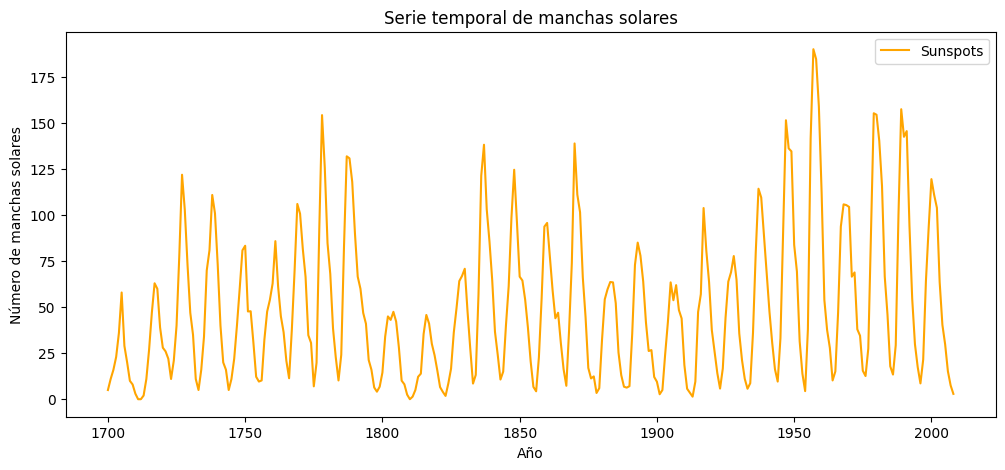


Datos normalizados:
     YEAR  SUNACTIVITY  SUNACTIVITY_norm
0  1700.0          5.0          0.026288
1  1701.0         11.0          0.057834
2  1702.0         16.0          0.084122
3  1703.0         23.0          0.120925
4  1704.0         36.0          0.189274

 Dataset normalizado guardado como 'sunspots_normalized.csv'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.datasets import sunspots

# Cargar el dataset
data = sunspots.load_pandas().data

# Mostrar primeras filas
print("Primeras filas del dataset:")
print(data.head())

# Visualización inicial de la serie completa
plt.figure(figsize=(12,5))
plt.plot(data['YEAR'], data['SUNACTIVITY'], color="orange", label="Sunspots")
plt.xlabel("Año")
plt.ylabel("Número de manchas solares")
plt.title("Serie temporal de manchas solares")
plt.legend()
plt.show()

# Normalización de los datos
scaler = MinMaxScaler(feature_range=(0,1))
data['SUNACTIVITY_norm'] = scaler.fit_transform(data[['SUNACTIVITY']])

# Mostrar los datos normalizados
print("\nDatos normalizados:")
print(data.head())

data.to_csv("sunspots_normalized.csv", index=False)
print("\n Dataset normalizado guardado como 'sunspots_normalized.csv'")


### **Implementacion de RNN Basica**



Epoch 5/30, Loss: 0.046749
Epoch 10/30, Loss: 0.037251
Epoch 15/30, Loss: 0.029555
Epoch 20/30, Loss: 0.019046
Epoch 25/30, Loss: 0.015688
Epoch 30/30, Loss: 0.012666


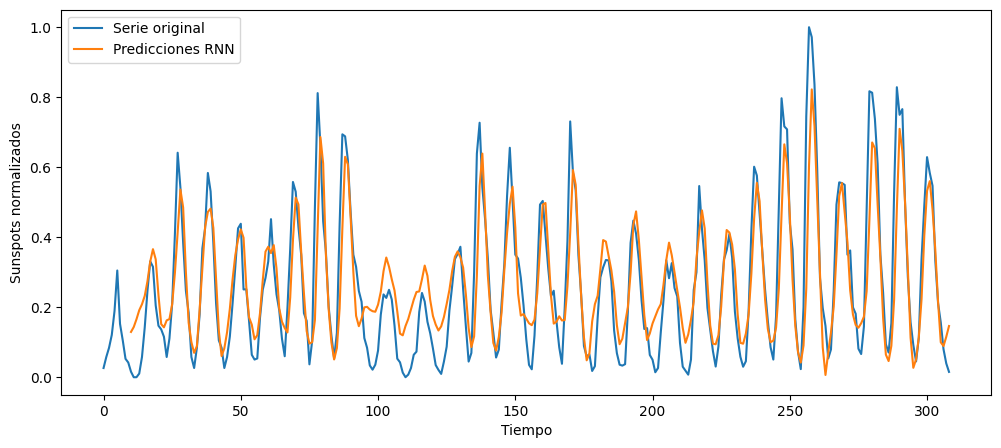

In [ ]:
    import torch
    import torch.nn as nn
    import numpy as np

# Crear dataset de secuencias con ventana de 10 pasos
def create_sequences(data, seq_length=10):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Usar la columna normalizada
series = data['SUNACTIVITY_norm'].values
seq_length = 10
X, y = create_sequences(series, seq_length)

# Convertir a tensores de PyTorch
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Definir el modelo RNN
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h = self.rnn(x)           # out: (batch, seq_len, hidden_size)
        out = out[:, -1, :]            # se toma solo el último paso
        out = self.fc(out)             # se pasa por la capa fully connected
        return out

# Instanciar el modelo
model = RNNModel()

# Definir función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Entrenamiento
epochs = 30
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_tensor)
    loss = criterion(output, y_tensor)

    loss.backward()
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

# Probar predicciones
model.eval()
with torch.no_grad():
    predictions = model(X_tensor).numpy()

# Visualizar resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(series, label="Serie original")
plt.plot(range(seq_length, seq_length+len(predictions)), predictions, label="Predicciones RNN")
plt.xlabel("Tiempo")
plt.ylabel("Sunspots normalizados")
plt.legend()
plt.show()
